<a href="https://colab.research.google.com/github/Hashhhhhhhh/Optimization-of-Quantum-Optics-Experimental-Setups/blob/main/Triangle_GHz_like_photonic_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUBO matrix Q (rows/cols in var order):
['-1.000', '-0.600', '-0.600', '-0.800', '+0.000', '+0.000']
['-0.600', '-1.000', '-0.600', '+0.000', '-0.800', '+0.000']
['-0.600', '-0.600', '-1.000', '+0.000', '+0.000', '-0.800']
['-0.800', '+0.000', '+0.000', '-0.300', '+0.500', '+0.500']
['+0.000', '-0.800', '+0.000', '+0.500', '-0.300', '+0.500']
['+0.000', '+0.000', '-0.800', '+0.500', '+0.500', '-0.300']

Simulated annealing results (top solutions):
Rank 1: x=[1, 1, 1, 1, 1, 0], energy=-9.4000
Rank 2: x=[1, 1, 1, 1, 0, 1], energy=-9.4000
Rank 3: x=[1, 1, 1, 0, 1, 1], energy=-9.4000

Brute-force best: {'best_x': [1, 1, 1, 1, 1, 0], 'best_energy': -9.399999999999999}

Candidate skeletons to refine (from SA):
[1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 0, 1]
[1, 1, 1, 0, 1, 1]


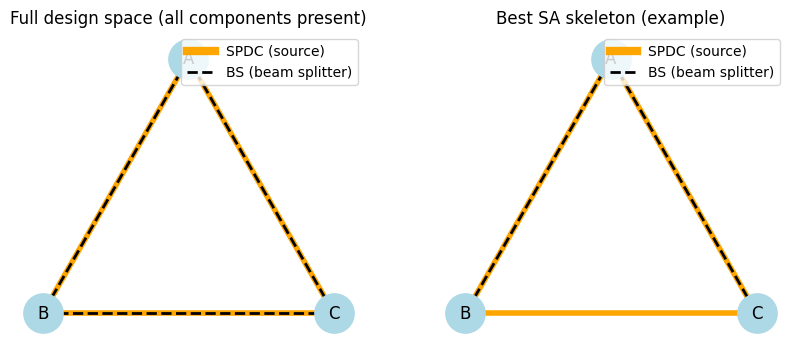


Optimizing skeleton: [1, 1, 1, 1, 1, 0]
step 1/1200 loss=0.721369 F=0.278631
step 120/1200 loss=0.000007 F=0.999993
step 240/1200 loss=-0.000000 F=1.000000
step 360/1200 loss=-0.000000 F=1.000000
step 480/1200 loss=-0.000000 F=1.000000
step 600/1200 loss=-0.000000 F=1.000000
step 720/1200 loss=0.000000 F=1.000000
step 840/1200 loss=-0.000000 F=1.000000
step 960/1200 loss=0.000000 F=1.000000
step 1080/1200 loss=-0.000000 F=1.000000
step 1200/1200 loss=-0.000000 F=1.000000
Best F found: 1.000000238418579
C vals (C110, C101, C011): [(0.8106741309165955+0.3855523467063904j), (0.8106741905212402+0.38554999232292175j), (0.8106680512428284+0.3855488896369934j)]

Optimizing skeleton: [1, 1, 1, 1, 0, 1]
step 1/1200 loss=0.923738 F=0.076262
step 120/1200 loss=0.000011 F=0.999989
step 240/1200 loss=0.000000 F=1.000000
step 360/1200 loss=0.000000 F=1.000000
step 480/1200 loss=0.000000 F=1.000000
step 600/1200 loss=0.000000 F=1.000000
step 720/1200 loss=0.000000 F=1.000000
step 840/1200 loss=0.000

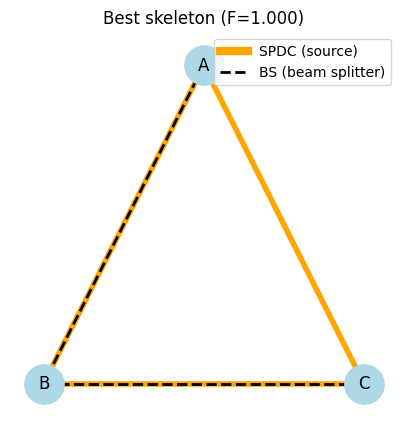

In [11]:
!pip install --quiet torch torchvision

import math
import cmath
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import time

# reproducibility
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

# 1) Problem setup (triangle experiment)
# We use 6 binary variables:
# indices: 0..5 represent:
# 0 - s_AB  (SPDC between A and B)
# 1 - s_AC  (SPDC between A and C)
# 2 - s_BC  (SPDC between B and C)
# 3 - bs_AB (beam-splitter between A-B)
# 4 - bs_AC (beam-splitter between A-C)
# 5 - bs_BC (beam-splitter between B-C)

var_names = ['s_AB','s_AC','s_BC','bs_AB','bs_AC','bs_BC']
n_vars = len(var_names)

# 2) Construct a QUBO matrix
diag_source_reward = -1.0   # reward for including a SPDC (more negative -> more encouraged)
diag_bs_reward = -0.3       # reward for including a BS (smaller)
source_bs_synergy = -0.8    # negative encourages selecting a source and its matching BS
source_pair_synergy = -0.6  # negative encourages selecting pairs of sources (superposition)
bs_conflict = 0.5           # positive penalizes selecting two BSs that might conflict

# Build empty Q
Q = np.zeros((n_vars, n_vars))

# Diagonals
Q[0,0] = diag_source_reward   # s_AB
Q[1,1] = diag_source_reward   # s_AC
Q[2,2] = diag_source_reward   # s_BC
Q[3,3] = diag_bs_reward       # bs_AB
Q[4,4] = diag_bs_reward       # bs_AC
Q[5,5] = diag_bs_reward       # bs_BC

# Pairwise: source-source synergy (encourage having multiple sources)
for i,j in [(0,1),(0,2),(1,2)]:
    Q[i,j] = source_pair_synergy
    Q[j,i] = Q[i,j]

# Source-BS synergy: link each source to the BS that mixes its modes
# mapping: s_AB <-> bs_AB (0 <-> 3), s_AC <-> bs_AC (1 <-> 4), s_BC <-> bs_BC (2 <-> 5)
for s,bs in [(0,3),(1,4),(2,5)]:
    Q[s,bs] = source_bs_synergy
    Q[bs,s] = Q[s,bs]

# BS-BS mild conflict
for i in [3,4,5]:
    for j in [3,4,5]:
        if i<j:
            Q[i,j] = bs_conflict
            Q[j,i] = bs_conflict

print("QUBO matrix Q (rows/cols in var order):")
for i in range(n_vars):
    print([f"{Q[i,j]:+.3f}" for j in range(n_vars)])

# 3) Simulated annealing solver for QUBO (simple implementation)
def qubo_energy(Q, x):
    # x: binary array of length n_vars (0/1)
    xv = np.array(x, dtype=float)
    return float(xv @ Q @ xv)

def random_neighbor(x):
    # flip one random bit
    y = x.copy()
    idx = random.randrange(len(x))
    y[idx] = 1 - y[idx]
    return y

def simulated_annealing_qubo(Q, n_iter=5000, T0=1.0, T_end=1e-3, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    n = Q.shape[0]

    x = [random.choice([0,1]) for _ in range(n)]
    best = x.copy()
    best_E = qubo_energy(Q, x)
    cur_E = best_E
    start_time = time.time()
    for k in range(n_iter):
        T = T0 * ((T_end/T0)**(k/(n_iter-1)))  # geometric cooling
        y = random_neighbor(x)
        yE = qubo_energy(Q, y)
        # metropolis
        dE = yE - cur_E
        if dE < 0 or random.random() < math.exp(-dE / max(T,1e-12)):
            x = y
            cur_E = yE
            if cur_E < best_E:
                best = x.copy()
                best_E = cur_E
    runtime = time.time()-start_time
    return {'best_x': best, 'best_energy': best_E, 'runtime': runtime}

n_runs = 8
sa_results = []
for r in range(n_runs):
    res = simulated_annealing_qubo(Q, n_iter=6000, T0=1.0, T_end=1e-4, seed=RNG_SEED + r)
    sa_results.append(res)

# Sorting unique solutions by energy
unique = {}
for res in sa_results:
    key = tuple(res['best_x'])
    if key not in unique or res['best_energy'] < unique[key]['best_energy']:
        unique[key] = res
sorted_sols = sorted(unique.items(), key=lambda kv: kv[1]['best_energy'])

print("\nSimulated annealing results (top solutions):")
for i,(key,res) in enumerate(sorted_sols[:6]):
    print(f"Rank {i+1}: x={list(key)}, energy={res['best_energy']:.4f}")

# Also computing brute force minimum for comparison (small space 2^6=64)
def brute_force_qubo(Q):
    n = Q.shape[0]
    best = None
    bestE = 1e12
    for v in range(1<<n):
        x = [(v>>i)&1 for i in range(n)]
        E = qubo_energy(Q, x)
        if E < bestE:
            bestE = E
            best = x.copy()
    return {'best_x': best, 'best_energy': bestE}

bf = brute_force_qubo(Q)
print("\nBrute-force best:", bf)

# picking top k skeletons
top_k = list(sorted_sols[:3])
candidate_skeletons = [list(k) for (k,res) in top_k]
print("\nCandidate skeletons to refine (from SA):")
for sk in candidate_skeletons:
    print(sk)


def draw_triangle_skeleton(x, ax=None, title="Graph"):
    # nodes: A=0,B=1,C=2
    # edges: e_AB(0), e_AC(1), e_BC(2)
    # BS edges: bs_AB(3), bs_AC(4), bs_BC(5)
    G = nx.Graph()
    G.add_nodes_from([0,1,2])
    # mapping for edges for visualization (we treat SPDC edges and BS edges with different styles)
    spdc_edges = []
    bs_edges = []
    if x[0]: spdc_edges.append((0,1))
    if x[1]: spdc_edges.append((0,2))
    if x[2]: spdc_edges.append((1,2))
    if x[3]: bs_edges.append((0,1))
    if x[4]: bs_edges.append((0,2))
    if x[5]: bs_edges.append((1,2))

    pos = {0:(0,0.7), 1:(-0.6,-0.2), 2:(0.6,-0.2)}
    if ax is None:
        plt.figure(figsize=(4,4))
        ax = plt.gca()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, labels={0:'A',1:'B',2:'C'}, font_size=12, ax=ax)
    if spdc_edges:
        nx.draw_networkx_edges(G, pos, edgelist=spdc_edges, width=4, edge_color='orange', style='solid', ax=ax, label='SPDC')
    if bs_edges:
        nx.draw_networkx_edges(G, pos, edgelist=bs_edges, width=2, edge_color='black', style='dashed', ax=ax, label='BS')
    # draw legend manual
    from matplotlib.lines import Line2D
    legend_elements = []
    if spdc_edges:
        legend_elements.append(Line2D([0],[0], color='orange', lw=6, label='SPDC (source)'))
    if bs_edges:
        legend_elements.append(Line2D([0],[0], color='black', lw=2, linestyle='--', label='BS (beam splitter)'))
    if legend_elements:
        ax.legend(handles=legend_elements, loc='upper right')
    ax.axis('off')

fig, axes = plt.subplots(1,2,figsize=(10,4))
draw_triangle_skeleton([1,1,1,1,1,1], ax=axes[0], title="Full design space (all components present)")
best_sa = sorted_sols[0][0]  # best solution tuple
draw_triangle_skeleton(list(best_sa), ax=axes[1], title="Best SA skeleton (example)")
plt.show()

# 4) Continuous optimization
# Map physical knobs -> final coefficients C110, C101, C011 as explained earlier.

def compute_outputs_from_physical(kappa_ab, P_ab, phi_ab,
                                  kappa_ac, P_ac, phi_ac,
                                  kappa_bc, P_bc, phi_bc,
                                  phiA, phiB, phiC,
                                  theta):
    # c = kappa * sqrt(P) * exp(i*phi_source)
    c_ab = kappa_ab * math.sqrt(max(0.0,P_ab)) * cmath.exp(1j*phi_ab)
    c_ac = kappa_ac * math.sqrt(max(0.0,P_ac)) * cmath.exp(1j*phi_ac)
    c_bc = kappa_bc * math.sqrt(max(0.0,P_bc)) * cmath.exp(1j*phi_bc)
    # apply local mode phases
    t_ab = c_ab * cmath.exp(1j*(phiA + phiB))
    t_ac = c_ac * cmath.exp(1j*(phiA + phiC))
    t_bc = c_bc * cmath.exp(1j*(phiB + phiC))
    # BS on A-B
    cos_t = math.cos(theta)
    sin_t = math.sin(theta)
    cos2 = math.cos(2*theta)
    C110 = t_ab * cos2
    C101 = t_ac * cos_t - t_bc * sin_t
    C011 = t_ac * sin_t + t_bc * cos_t
    return C110, C101, C011


def torch_outputs_from_params(params):
    # params is a 10-dim torch tensor (raw variables) arranged as:
    # [r_ab, r_ac, r_bc,   p_ab, p_ac, p_bc,    mA, mB, mC,    t_theta ]
    # where r_x are raw pump amplitudes -> P = softplus(r)
    # p_x are source phases (unbounded) -> use raw directly (interpreted as rad)
    # mA/mB/mC are mode phases
    # t_theta is raw mapped via sigmoid to [0, pi/2]
    r_ab, r_ac, r_bc, p_ab, p_ac, p_bc, mA, mB, mC, t_theta = torch.unbind(params)
    # map pumps: positive via softplus
    P_ab = torch.nn.functional.softplus(r_ab)
    P_ac = torch.nn.functional.softplus(r_ac)
    P_bc = torch.nn.functional.softplus(r_bc)
    # source phases:
    phi_ab = p_ab
    phi_ac = p_ac
    phi_bc = p_bc
    # mode phases:
    phiA = mA
    phiB = mB
    phiC = mC
    # theta in [0, pi/2]
    theta = 0.5 * math.pi * torch.sigmoid(t_theta)
    # kappa: set to 1.0 for all (can be changed)
    k_ab = k_ac = k_bc = 1.0

    c_ab = k_ab * torch.sqrt(P_ab + 1e-12) * torch.exp(1j * phi_ab)
    c_ac = k_ac * torch.sqrt(P_ac + 1e-12) * torch.exp(1j * phi_ac)
    c_bc = k_bc * torch.sqrt(P_bc + 1e-12) * torch.exp(1j * phi_bc)
    t_ab = c_ab * torch.exp(1j * (phiA + phiB))
    t_ac = c_ac * torch.exp(1j * (phiA + phiC))
    t_bc = c_bc * torch.exp(1j * (phiB + phiC))
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    cos2 = torch.cos(2.0 * theta)
    C110 = t_ab * cos2
    C101 = t_ac * cos_t - t_bc * sin_t
    C011 = t_ac * sin_t + t_bc * cos_t
    # compute fidelity F = |S|^2 / (3 N), with S = sum C, N = sum |C|^2
    S = C110 + C101 + C011
    N = (torch.abs(C110)**2 + torch.abs(C101)**2 + torch.abs(C011)**2) + 1e-12
    F = (torch.abs(S)**2) / (3.0 * N)
    return F, (C110, C101, C011), N

# 5) Running continuous optimization for each candidate skeleton

device = torch.device('cuda')

def optimize_continuous_for_skeleton(skeleton_bits, n_steps=1000, lr=0.05, verbose=False):
    # skeleton_bits: list of 6 bits. If a source bit is 0, we will initialize its pump low and keep it (but allowed to rise).
    # However we prefer to fix pumps of excluded sources to zero to strictly respect skeleton:
    # We'll set initial raw pump small for excluded items and then clamp them to very negative values during optimization.
    # Another option: optimize only the continuous knobs for included components; here we bias excluded to near 0.
    included_sources = [skeleton_bits[i] for i in (0,1,2)]
    included_bss = [skeleton_bits[i] for i in (3,4,5)]
    # Initialize params
    # raw amps r ~ small positive; phs random small; mode phases small; theta random
    init = np.zeros(10, dtype=float)
    # r_ab, r_ac, r_bc
    for i in range(3):
        init[i] = 0.1 if included_sources[i] else -5.0  # excluded sources get very negative raw pump -> softplus ~ 0
    # p_ab, p_ac, p_bc (source phases)
    init[3:6] = np.random.uniform(-0.5,0.5, size=3)
    # mode phases
    init[6:9] = np.random.uniform(-0.5,0.5, size=3)
    # theta raw
    init[9] = np.random.uniform(-1.0,1.0)
    params = torch.tensor(init, dtype=torch.float32, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr)
    best_F = -1.0
    best_state = None
    for step in range(1, n_steps+1):
        optimizer.zero_grad()
        F, Cs, N = torch_outputs_from_params(params)
        loss = 1.0 - F  # minimize
        loss.backward()
        optimizer.step()
        if (step % (n_steps//10) == 0) or step==1:
            if verbose:
                print(f"step {step}/{n_steps} loss={loss.item():.6f} F={F.item():.6f}")
        if F.item() > best_F:
            best_F = F.item()
            best_state = params.detach().cpu().numpy().copy()

    final_params = torch.tensor(best_state, dtype=torch.float32)
    F_final, Cs_final, N_final = torch_outputs_from_params(final_params)
    return {'skeleton': skeleton_bits, 'best_params': best_state, 'best_F': best_F,
            'C_vals': [complex(C.item()) for C in Cs_final], 'N': float(N_final.item())}
results = []
for sk in candidate_skeletons:
    print("\nOptimizing skeleton:", sk)
    res = optimize_continuous_for_skeleton(sk, n_steps=1200, lr=0.03, verbose=True)
    print("Best F found:", res['best_F'])
    print("C vals (C110, C101, C011):", res['C_vals'])
    results.append(res)
print("\nOptimizing full-graph baseline (all components present)...")
full_res = optimize_continuous_for_skeleton([1,1,1,1,1,1], n_steps=1200, lr=0.03, verbose=True)
print("Full-graph best F:", full_res['best_F'])
print("Full-graph C vals:", full_res['C_vals'])

#Best overall skeleton

all_results = results + [full_res]
sorted_by_F = sorted(all_results, key=lambda r: -r['best_F'])
print("\nTop designs by fidelity:")
for i,r in enumerate(sorted_by_F[:4]):
    print(f"Rank {i+1}: skeleton={r['skeleton']}  best_F={r['best_F']:.6f}  N={r['N']:.4f}  Cvals={r['C_vals']}")

best = sorted_by_F[0]
print("\nBest skeleton chosen:", best['skeleton'], "with F=", best['best_F'])

# visualizing best skeleton
fig, ax = plt.subplots(1,1,figsize=(5,5))
draw_triangle_skeleton(best['skeleton'], ax=ax, title=f"Best skeleton (F={best['best_F']:.3f})")
plt.show()


In [12]:
# suppose 'res' is the returned dict from optimize_continuous_for_skeleton(...)
best_state = res['best_params']   # numpy array length 10 (as in the notebook)
# decode to physical knobs (matching your mapping)
import numpy as np, math
r_ab, r_ac, r_bc, p_ab, p_ac, p_bc, mA, mB, mC, t_theta = best_state
P_ab = np.log1p(np.exp(r_ab))  # softplus approx if you used softplus
P_ac = np.log1p(np.exp(r_ac))
P_bc = np.log1p(np.exp(r_bc))
theta = 0.5*math.pi*(1/(1+math.exp(-t_theta)))  # sigmoid -> [0,pi/2]
print("Pumps:", P_ab, P_ac, P_bc)
print("Source phases:", p_ab, p_ac, p_bc)
print("Mode phases:", mA, mB, mC)
print("BS theta (rad):", theta)


Pumps: 1.3588358 1.2655913 0.2561004
Source phases: 1.0178915 -0.8719324 0.94993085
Mode phases: -0.9288454 0.3909082 -0.8608972
BS theta (rad): 1.2081050908565465


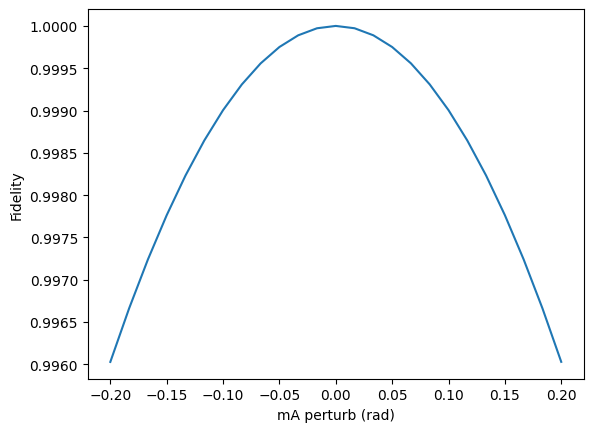

In [13]:
#Robustness test:
import numpy as np
base = np.array(res['best_params'])
deltas = np.linspace(-0.2,0.2,25)  # radian perturbation for mode phases
Fs = []
for d in deltas:
    test = base.copy()
    test[6] += d  # perturb mA
    F_test,_,_ = torch_outputs_from_params(torch.tensor(test,dtype=torch.float32))
    Fs.append(float(F_test))
# plot deltas vs Fs
import matplotlib.pyplot as plt
plt.plot(deltas, Fs); plt.xlabel("mA perturb (rad)"); plt.ylabel("Fidelity"); plt.show()
